# DL Assignment 3 - CS23MTECH11026 - Bhargav Patel

In [ ]:
import torch
import math
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

# Question 1 - Self-Attention for Object Recognition with CNNs:
Implement a sample CNN with one or more self-attention layer(s) for performing object recognition over CIFAR-10 dataset. You have to implement the self-attention layer yourself and use it in the forward function defined by you. All other layers (fully connected, nonlinearity, conv layer, etc.) can be bulit-in implementations. The network can be a simpler one (e.g., it may have 1x Conv, 4x [Conv followed by SA], 1x Conv, and 1x GAP).

<br>

#### **I have implemented the below given architecture**
Reference: https://docs.google.com/presentation/d/15ifYMrvQtDrp20H8JWbP94Tifh8OWHlxXt1hiGfpyh0/edit#slide=id.g193b41dbc2d_0_262

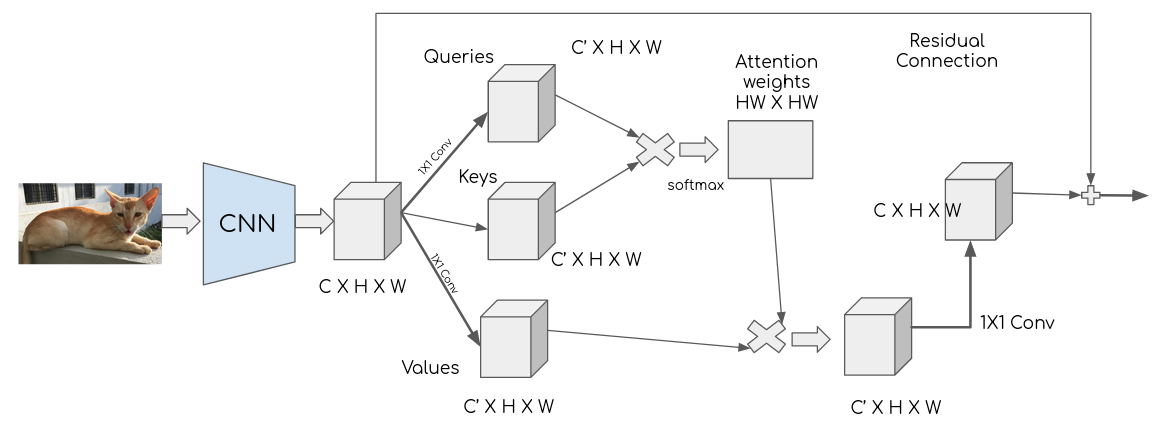

### **Downloading the dataset and doing required transformations**

In [ ]:
# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(), # numpy array to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # subtract 0.5 from mean of all channel and divide by 0.5 form the SD of all channel
])

# After download, Transforming the dataset as specified in transform (ToTensor, Normalize)
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Define the batch size
batch_size = 64

# Move the dataset and dataloader to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified
cuda


### **Self Attention Layer**

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.wq = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.wk = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.wv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, channels, width, height = x.size()

        # Project features to query, key, and value
        Q = self.wq(x).view(batch_size, -1, width*height).permute(0, 2, 1)  # B x (N) x C
        K = self.wk(x).view(batch_size, -1, width*height)  # B x C x (N)
        QK = torch.bmm(Q, K)  # batch matrix multiplication

        # Compute attention weights
        attention = F.softmax(QK, dim=-1)

        # Project features to value
        V = self.wv(x).view(batch_size, -1, width*height)  # B x C x N

        # Compute self-attended features
        out = torch.bmm(V, attention.permute(0, 2, 1))
        out = out.view(batch_size, channels, width, height)

        # Apply scaling factor
        out = self.gamma * out + x
        return out


### **Complete Architecture - sequence of CNN & Self attention layer**

In [ ]:
class CNNWithSelfAttention(nn.Module):
    def __init__(self):
        super(CNNWithSelfAttention, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.sa1 = SelfAttention(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.sa2 = SelfAttention(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.sa3 = SelfAttention(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.sa4 = SelfAttention(256)
        self.conv5 = nn.Conv2d(256, 10, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.sa1(x)
        x = F.relu(self.conv2(x))
        x = self.sa2(x)
        x = F.relu(self.conv3(x))
        x = self.sa3(x)
        x = F.relu(self.conv4(x))
        x = self.sa4(x)
        x = F.relu(self.conv5(x))
        x = self.pool(x)
        x = x.view(-1, 10)
        return x

### **Initialization - Training - Testing**

In [ ]:
# Instantiate the model, loss function, and optimizer
model = CNNWithSelfAttention().to(device)
lossfunction = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_history_CNN = []

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    training_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = lossfunction(outputs, labels)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()

        # Compute training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    print('Epoch %d, Training Loss: %.4f, Training Accuracy: %.2f %%' % (epoch+1, training_loss / len(train_loader), train_accuracy))
    loss_history_CNN.append(training_loss)

    # Evaluate the model on test set
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    print('Accuracy on test set: %.2f %%' % test_accuracy)

Epoch 1, Training Loss: 1.9714, Training Accuracy: 28.96 %
Accuracy on test set: 43.49 %
Epoch 2, Training Loss: 1.2454, Training Accuracy: 54.90 %
Accuracy on test set: 61.18 %
Epoch 3, Training Loss: 1.0111, Training Accuracy: 64.01 %
Accuracy on test set: 64.95 %
Epoch 4, Training Loss: 0.8810, Training Accuracy: 68.73 %
Accuracy on test set: 70.06 %
Epoch 5, Training Loss: 0.7861, Training Accuracy: 72.43 %
Accuracy on test set: 73.10 %


<br>
<br>
<br>
<br>

# Question 2 - Object Recognition with Vision Transformer:
Implement and train an Encoder only Transformer (ViT-like) for the above object recognition task. In other words, implement multi-headed self-attention for the image classification (i.e., appending a < class > token to the image patches that are accepted as input tokens). Compare the performance of the two implementations (try to keep the number of parameters to be comparable and use the same amount of training and testing data).

### **I have used the below given architecture that was well explained in the medium blog post which perfectly aligns with the implementation asked in the question.**
----
Reference (medium blog post) - https://medium.com/@brianpulfer/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c

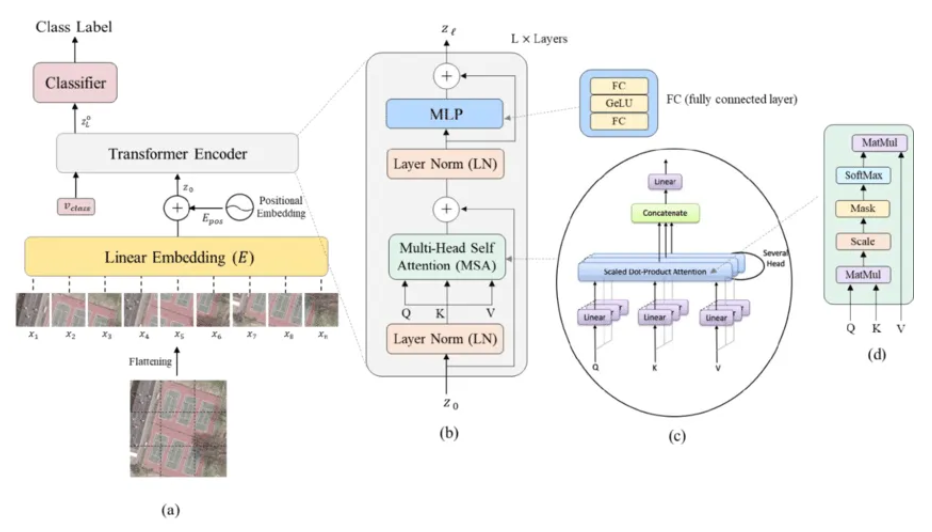

### **Downloading the dataset and doing required transformations**

In [ ]:
# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(), # numpy array to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # subtract 0.5 from mean of all channel and divide by 0.5 form the SD of all channel
])

# After download, Transforming the dataset as specified in transform (ToTensor, Normalize)
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Define the batch size
batch_size = 64

# Move the dataset and dataloader to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified
cuda


### **Generating Patches of the input images**

In [ ]:
def generate_patches(images, n_patches):
    n, c, h, w = images.shape

    assert h == w, "Patchify method is implemented for square images only"

    patches = torch.zeros(n, n_patches**2, h * w * c // n_patches**2)
    patch_size = h // n_patches

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[
                    :,
                    i * patch_size : (i + 1) * patch_size,
                    j * patch_size : (j + 1) * patch_size,
                ]
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches

### **Multi headed self attention layer**

In [ ]:
class multi_headed_selfattention(nn.Module):
    def __init__(self, d, n_heads=2):
        super(multi_headed_selfattention, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head : (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head**0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

### **Assigning Positional Embedding to the image patches**

In [ ]:
def pos_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = (
                np.sin(i / (10000 ** (j / d)))
                if j % 2 == 0
                else np.cos(i / (10000 ** ((j - 1) / d)))
            )
    return result

### **Vision Transformer Block**

In [ ]:
class ViT_block(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(ViT_block, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = multi_headed_selfattention(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d),
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out

### **Vision Transformer architecture**

In [ ]:
class ViT(nn.Module):
    def __init__(self, chw, n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        # Super constructor
        super(ViT, self).__init__()

        # Attributes
        self.chw = chw  # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d

        # Input and patches sizes
        assert (
            chw[1] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"
        assert (
            chw[2] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional embedding
        self.register_buffer("positional_embeddings", pos_embeddings(n_patches**2 + 1, hidden_d), persistent=False,)

        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList([ViT_block(hidden_d, n_heads) for _ in range(n_blocks)])

        # 5) Classification MLPk
        self.mlp = nn.Sequential(nn.Linear(self.hidden_d, out_d), nn.Softmax(dim=-1))

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = generate_patches(images, self.n_patches).to(self.positional_embeddings.device)

        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)

        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)

        # Transformer Blocks
        for block in self.blocks:
            out = block(out)

        # Getting the classification token only
        out = out[:, 0]

        return self.mlp(out)  # Map to output dimension, output category distribution

### **Initialize - Training - Testing**

In [ ]:
model = ViT((3, 32, 32), n_patches=8, n_blocks=2, hidden_d=64, n_heads=4, out_d=10).to(device)
lossfunction = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_history_MHSA = []

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    model.train()
    for batch in train_loader:
        x, y = batch
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_hat = model(x)
        loss = lossfunction(y_hat, y)
        train_loss += loss.detach().cpu().item() / len(train_loader)

        loss.backward()
        optimizer.step()

        _, predicted = torch.max(y_hat, 1)
        total_train += y.size(0)
        correct_train += (predicted == y).sum().item()

    train_accuracy = 100 * correct_train / total_train
    print("Epoch %d, Training Loss: %.4f, Training Accuracy: %.2f %%" % (epoch+1, train_loss, train_accuracy))
    loss_history_MHSA.append(train_loss)

    # Test loop
    with torch.no_grad():
        correct_test, total_test = 0, 0
        test_loss = 0.0
        model.eval()
        for batch in test_loader:
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = lossfunction(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(test_loader)

            _, predicted = torch.max(y_hat, 1)
            correct_test += (predicted == y).sum().item()
            total_test += y.size(0)

        test_accuracy = 100 * correct_test / total_test
        print('Accuracy on test set: %.2f %%' % test_accuracy)

Epoch 1, Training Loss: 2.1465, Training Accuracy: 30.22 %
Accuracy on test set: 37.60 %
Epoch 2, Training Loss: 2.0561, Training Accuracy: 39.82 %
Accuracy on test set: 41.98 %
Epoch 3, Training Loss: 2.0298, Training Accuracy: 42.55 %
Accuracy on test set: 43.11 %
Epoch 4, Training Loss: 2.0046, Training Accuracy: 45.14 %
Accuracy on test set: 45.97 %
Epoch 5, Training Loss: 1.9867, Training Accuracy: 46.88 %
Accuracy on test set: 47.66 %


<br>
<br>
<br>
<br>

#### **For more number of epochs the accuracy increases but due to extreme time requirement for running wiht more epoch I have done with 5 epochs only and below is the proof for, accuracy increases as epochs increases**

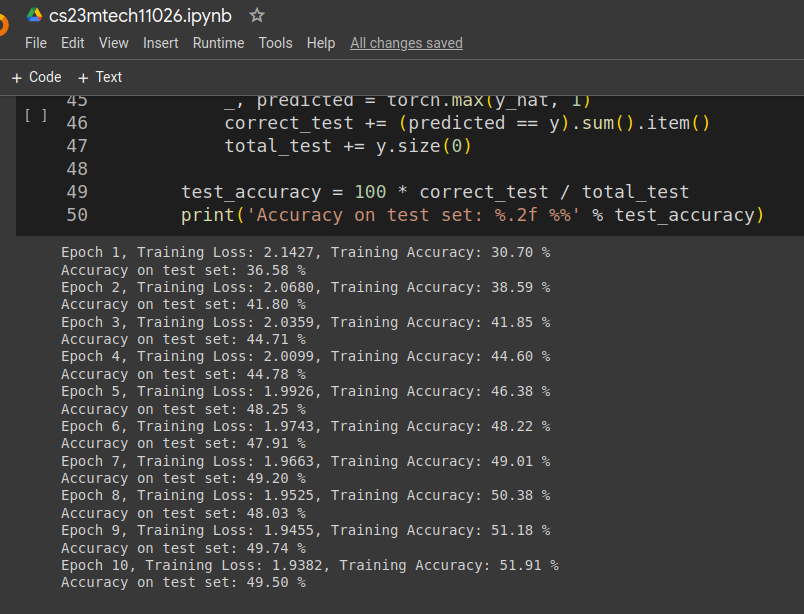

##### **Earlier in the training and testing section of the CNN with attention code. I forgot to divide the loss by len(train_loss). So below is the implementatoin for that.**

In [ ]:
train_loader_length = len(train_loader)
normalized_loss_history_CNN = [loss / train_loader_length for loss in loss_history_CNN]

### **Comparing Performance of both the implementation**
Self-Attention for Object Recognition with CNNs:
<br>
Object Recognition with Vision Transformer:

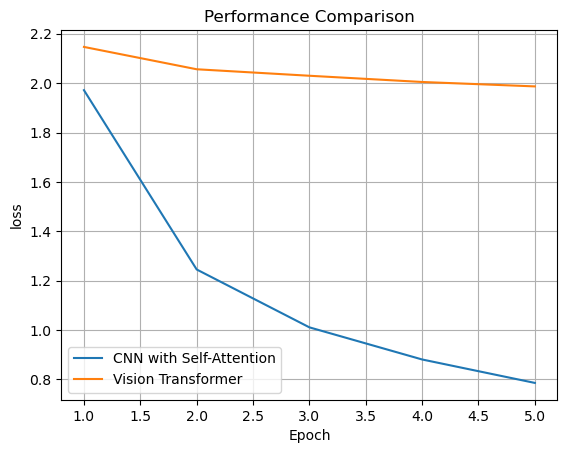

In [ ]:
# Plotting the performance comparison
plt.plot(range(1, num_epochs + 1), normalized_loss_history_CNN, label='CNN with Self-Attention')
plt.plot(range(1, num_epochs + 1), loss_history_MHSA, label='Vision Transformer')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Performance Comparison')
plt.legend()
plt.grid(True)
plt.show()